# Data Processing and Model Training - Titanic Dataset

In this notebook we define a proof of concept data processing including both the preprocessing and preparation of the data and the classification model as well. Bundling these two components together allows us to to tune both at the same time to find best fit during the training, and later deploy them as a unit.

### Package imports

The warnings library is used to supress sklearn warning and keep the cell outputs clean. For example some parameters during the hyperparameter training might not be compatible. In these cases sklearn puts out a warning, to tell the user of this issue, but since this doesn't affect the rest of the parameter combinations, and the hyperparameter tuning concludes successfully.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yaml

import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature
import pandas as pd
from minio import Minio
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from src.data.pipeline import load_config
from src.data.pipeline import load_pipeline
from src.data.pipeline import load_search_params
from src.utils.settings import settings

In [3]:
os.environ["AWS_ACCESS_KEY_ID"] = settings.aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = settings.aws_secret_access_key
os.environ["MLFLOW_S3_ENDPOINT_URL"] = settings.mlflow_s3_endpoint_url

!! DEPRECATED

## Configurations

**features_to_use**: This list contains the whitelist of column names which contain relevant information for the training.

**numeric_features**, **categorical_features**: These lists contain the columns names of numeric and categorical features, and are used to separate them so that we can apply different transformation steps to them.

**param_grid**: Grid search parameters for the hyperparameter tuning.

!! DEPRECATED

## Data processing pipeline definition

Here we define the data processing pipeline. The parameters of each component, such as the strategy of the SimpleImputer, are just default values for testing purposes. The hyperparameter tuning is going to overwrite them.

The categorical and numerical features are handled separately. First we impute the missing values in them, then categorical values are encoded, while numerical values are scaled.
After the transformation steps above, we apply a feature selection layer, and then we connect it's output to the classifier.

## MLflow setup

In [4]:
mlflow.set_tracking_uri(uri=settings.mlflow_tracking_url)
mlflow.set_experiment(experiment_name=settings.mlflow_experiment_name)
mlflow.autolog(
    log_input_examples=True,
    log_model_signatures=True,
    log_models=False,
    log_datasets=True,
    log_traces=True,
)

run_name = f"train_{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}"

2025/09/08 14:46:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


### Cloud storage bucket initiation

In [5]:
client = Minio(
    settings.minio_url,
    access_key=settings.aws_access_key_id,
    secret_key=settings.aws_secret_access_key,
    secure=False,
)

if not client.bucket_exists(settings.minio_bucket_name):
    print("MLflow bucket doesn't exist. Creating...")
    client.make_bucket(settings.minio_bucket_name)
else:
    print("Using existing MLflow bucket")

Using existing MLflow bucket


## Data import

In [6]:
with open('../config/data_config.yaml', 'r') as file:
    metadata = yaml.safe_load(file)

index_columns = metadata['index_columns']
target_column = metadata['target_column']

df_train = pd.read_csv('../data/titanic.csv', index_col=index_columns)
X_train = df_train.drop(columns=target_column)
y_train = df_train[target_column]

## Training

For the training we are using grid search hyperparameter tuning with stratified K-fold crossvalidation.

In [7]:
config = load_config('../config/pipeline_config.yaml')
pipeline_config = config.get("pipeline")
search_params_config = config.get("search_parameters", [])

pipeline = load_pipeline(pipeline_config)
search_params = load_search_params(search_params_config)

print(pipeline)
for param in search_params:
    print(param)

Pipeline(steps=[('data_pipe',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Fare']),
                                                                  ('cat',
                                             

In [8]:
with mlflow.start_run(
    run_name=run_name,
    log_system_metrics=True,
    tags={'test_tag': "hello"}
):
    run_id = mlflow.active_run().info.run_id

    skf = StratifiedKFold(n_splits=5, shuffle=False)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=search_params, scoring="accuracy", cv=skf, verbose=1)

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    signature = infer_signature(X_train.head(), best_model.predict(X_train.head()))

    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        name=settings.mlflow_model_name,
        signature=signature,
        input_example=X_train.head(),
        registered_model_name=settings.mlflow_registered_model_name,
    )

2025/09/08 14:46:20 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/09/08 14:46:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025/09/08 14:46:27 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/09/08 14:46:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/09/08 14:46:28 INFO mlflow.sklearn.utils: Logging the 5 best runs, 55 runs will be omitted.


🏃 View run industrious-slug-249 at: http://127.0.0.1:8080/#/experiments/1/runs/465b60e5b3694f2cb7fddf7c4fc2e91e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run thundering-dog-727 at: http://127.0.0.1:8080/#/experiments/1/runs/28af97fe21ca46faa41adb74944cf647
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run bustling-roo-1 at: http://127.0.0.1:8080/#/experiments/1/runs/66a45b820e694664bd1aecef3a824030
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run entertaining-jay-148 at: http://127.0.0.1:8080/#/experiments/1/runs/14049880594d418eb61dd6feebe02448
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run youthful-bass-356 at: http://127.0.0.1:8080/#/experiments/1/runs/810ad38569e944a9912c7f7e90b0e87f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Registered model 'sklearn-logreg-model' already exists. Creating a new version of this model...
2025/09/08 14:46:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sklearn-logreg-model, version 12
Created version '12' of model 'sklearn-logreg-model'.
2025/09/08 14:46:32 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/08 14:46:32 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


🏃 View run train_20250908144620 at: http://127.0.0.1:8080/#/experiments/1/runs/32a756af13134dc48bd880643bf83d90
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Tag the trained registered model as "staging"

In [9]:
model_version = mlflow.search_model_versions(filter_string=f"run_id='{run_id}'")[-1]

client = mlflow.MlflowClient()
client.set_model_version_tag(
    name=settings.mlflow_registered_model_name,
    version=model_version.version,
    key="stage",
    value="staging",
)

The best parameters and the accuracy score of the model:

In [10]:
print("Best Parameters found:\n")
for k, v in grid_search.best_params_.items():
    print(f"{k}: {v}")
print("")
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters found:

classifier: LogisticRegression()
classifier__C: 0.1
classifier__solver: lbfgs
data_pipe__feature_selector__k: 1
data_pipe__preprocessor__cat__imputer__strategy: most_frequent
data_pipe__preprocessor__num__imputer__strategy: mean
data_pipe__preprocessor__num__scaler: None

Best Cross-Validation Score: 0.7867365513778168


# Evaluation

You can see the best fitted model parameters above. This classifier reached a training accuracy of ~78.68%.

This model chose to only 'Sex_female' column, which is created from the 'Sex' column using one-hot encoding.

On the test set this lucky choice results in 100% accuracy, but only because in the training set all female passengers survive and all males die.

In [11]:
df_test = pd.read_csv('../data/titanic.csv', index_col=index_columns)
X_test = df_test.drop(columns=target_column)
y_test = df_test[target_column]

y_pred = best_model.predict(X_test)

print("Accuracy of the model on the test dataset:", accuracy_score(y_test, y_pred))

Accuracy of the model on the test dataset: 0.7867564534231201


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       549
           1       0.74      0.68      0.71       342

    accuracy                           0.79       891
   macro avg       0.78      0.77      0.77       891
weighted avg       0.78      0.79      0.78       891



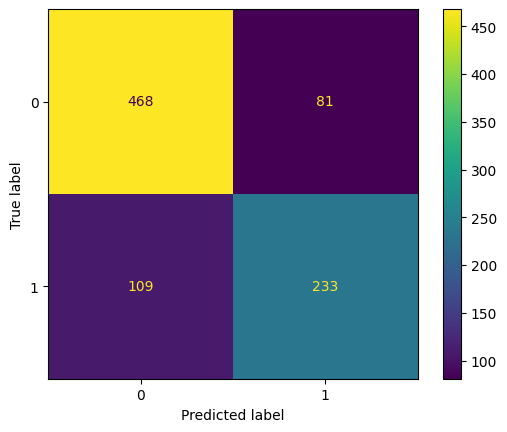

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()